# Loading the model

In [1]:
# from teacher_train import val_transform, FilteredLymphoMNIST, get_dataloaders
# from teacher_train import WeightedRandomSampler, balanced_weights
from LymphoMNIST.LymphoMNIST import LymphoMNIST
from torchvision import transforms
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
import torch


In [2]:
# Dataset class to filter by labels
class FilteredLymphoMNIST(Dataset):
    def __init__(self, original_dataset, labels_to_keep):
        self.original_dataset = original_dataset
        self.labels_to_keep = labels_to_keep
        self.label_map = {label: i for i, label in enumerate(labels_to_keep)}
        self.indices = [i for i, (_, label) in enumerate(original_dataset) if label in labels_to_keep]

    def __getitem__(self, index):
        original_index = self.indices[index]
        image, label = self.original_dataset[original_index]
        return image, self.label_map[label.item()]

    def __len__(self):
        return len(self.indices)
    
# Function to get dataloaders
def get_dataloaders(train_ds, val_ds, split=(0.5, 0.5), batch_size=64, sampler=None, *args, **kwargs):
    lengths = [int(len(val_ds) * frac) for frac in split]
    lengths[1] += len(val_ds) - sum(lengths)  # Correct split length sum
    val_ds, test_ds = torch.utils.data.random_split(val_ds, lengths)

    shuffle = False if sampler else True
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle, sampler=sampler, *args, **kwargs)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, *args, **kwargs)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, *args, **kwargs)

    return train_dl, val_dl, test_dl

# Dataset and data augmentation classes
class ConvertToRGB:
    def __call__(self, tensor):
        if tensor.shape[0] == 1:
            tensor = tensor.repeat(3, 1, 1)
        return tensor
    

# # Balanced weights function for weighted sampling
# def balanced_weights(dataset, nclasses):
#     count = [0] * nclasses
#     for _, label in dataset:
#         count[label] += 1
#     N = float(sum(count))
#     weight_per_class = [N / float(count[i]) for i in range(nclasses)]
#     return [weight_per_class[label] for _, label in dataset]


In [3]:
# our hyperparameters
params = {
    'lr': 1e-5,
    'batch_size': 16,
    'epochs': 10000,
    'model': "Teacher_final-3c",
    'im_size': 120,
}



In [4]:
# Define transforms
im_size = params['im_size']
val_transform = transforms.Compose([
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.4819], [0.1484]),
    ConvertToRGB()
])

In [6]:

# Initialize dataset
original_train_ds = LymphoMNIST(root='../dataset', train=True, download=True, transform=val_transform, num_classes=3)
original_test_ds = LymphoMNIST(root='../dataset', train=False, download=True, transform=val_transform, num_classes=3)


# Specify labels to keep
labels_to_keep = [0, 1] # 0: B, 1: T4, 2: T8

# Initialize filtered dataset with labels to keep
train_ds = FilteredLymphoMNIST(original_train_ds, labels_to_keep)
test_ds= FilteredLymphoMNIST(original_test_ds, labels_to_keep)

# weights = balanced_weights(train_ds, len(labels_to_keep))
# sampler = WeightedRandomSampler(weights, len(weights))
# Create the dataloaders
train_dl, val_dl, test_dl = get_dataloaders(train_ds,
                                            test_ds,
                                            split=(0.5, 0.5),
                                            batch_size=params['batch_size'],
                                            # sampler=sampler,
                                            num_workers=4
                                           )

Dataset already exists. Skipping download.
Dataset already exists. Skipping download.


In [7]:
import torch
from torchvision import models
from torch import nn

def calculate_accuracy(loader, model, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy



device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Load the model
model = models.resnet50()
model.fc = nn.Linear(model.fc.in_features, len(labels_to_keep))

# Load the saved weights and map them to the correct device
model.load_state_dict(torch.load("../checkpoint/Final_models/Teacher_imsize-120_30 September 22:37.pt", map_location=device))

model = model.to(device)


In [8]:
def evaluate_model(model, dataloader, device):
    y_pred = []
    y_true = []

    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        for image, target in dataloader:
            image, target = image.to(device), target.to(device)
            outputs = model(image)
            output = (torch.max(outputs, 1)[1]).data.cpu().numpy()
            y_pred.extend(output)  # Save Prediction
            target = target.data.cpu().numpy()
            y_true.extend(target)  # Save target

    return y_true, y_pred

In [ ]:
from torchsummary import summary
summary(model, (3, 120, 120))

In [9]:
# Calculate and print accuracies
train_acc = calculate_accuracy(train_dl, model, device)
print(f'Train Accuracy: {train_acc:.2f}%')



Train Accuracy: 99.82%


In [10]:
val_acc = calculate_accuracy(val_dl, model, device)
print(f'Validation Accuracy: {val_acc:.2f}%')



Validation Accuracy: 97.75%


In [11]:
test_acc = calculate_accuracy(test_dl, model, device)
print(f'Test Accuracy: {test_acc:.2f}%')

Test Accuracy: 97.65%


## Report scores

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

def get_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    auroc = roc_auc_score(y_true, y_pred, average='weighted', multi_class='ovr')
    accuracy = accuracy_score(y_true, y_pred)
    
    return precision, recall, f1, auroc, accuracy

# Evaluate the model on the validation set
y_true, y_pred = evaluate_model(model, test_dl, device)

# Get the metrics
precision, recall, f1, auroc, accuracy = get_metrics(y_true, y_pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'AUROC: {auroc:.2f}')
print(f'Accuracy: {accuracy:.2f}')

Precision: 0.98
Recall: 0.98
F1 Score: 0.98
AUROC: 0.97
Accuracy: 0.98


# Train vs validation accuracy

In [13]:
import json
import numpy as np

# Replace 'path/to/your/file.json' with the actual path to your JSON file
json_file_path = 'train_acc.json'

# Load the JSON data
with open(json_file_path, 'r') as file:
    data = json.load(file)


# Extract 'x' and 'y' values
train_x_values = data[0]['x']
train_y_values = data[0]['y']

# Convert lists to NumPy arrays
train_x_values = np.array(train_x_values)
train_y_values = np.array(train_y_values)

In [14]:
import json
import numpy as np

# Replace 'path/to/your/file.json' with the actual path to your JSON file
json_file_path = 'val_acc.json'

# Load the JSON data
with open(json_file_path, 'r') as file:
    data = json.load(file)


# Extract 'x' and 'y' values
val_x_values = data[0]['x']
val_y_values = data[0]['y']

# Convert lists to NumPy arrays
val_x_values = np.array(val_x_values)
val_y_values = np.array(val_y_values)

In [15]:
# find a specific value index
index = np.where(train_x_values == 200)
print(index)


(array([199]),)


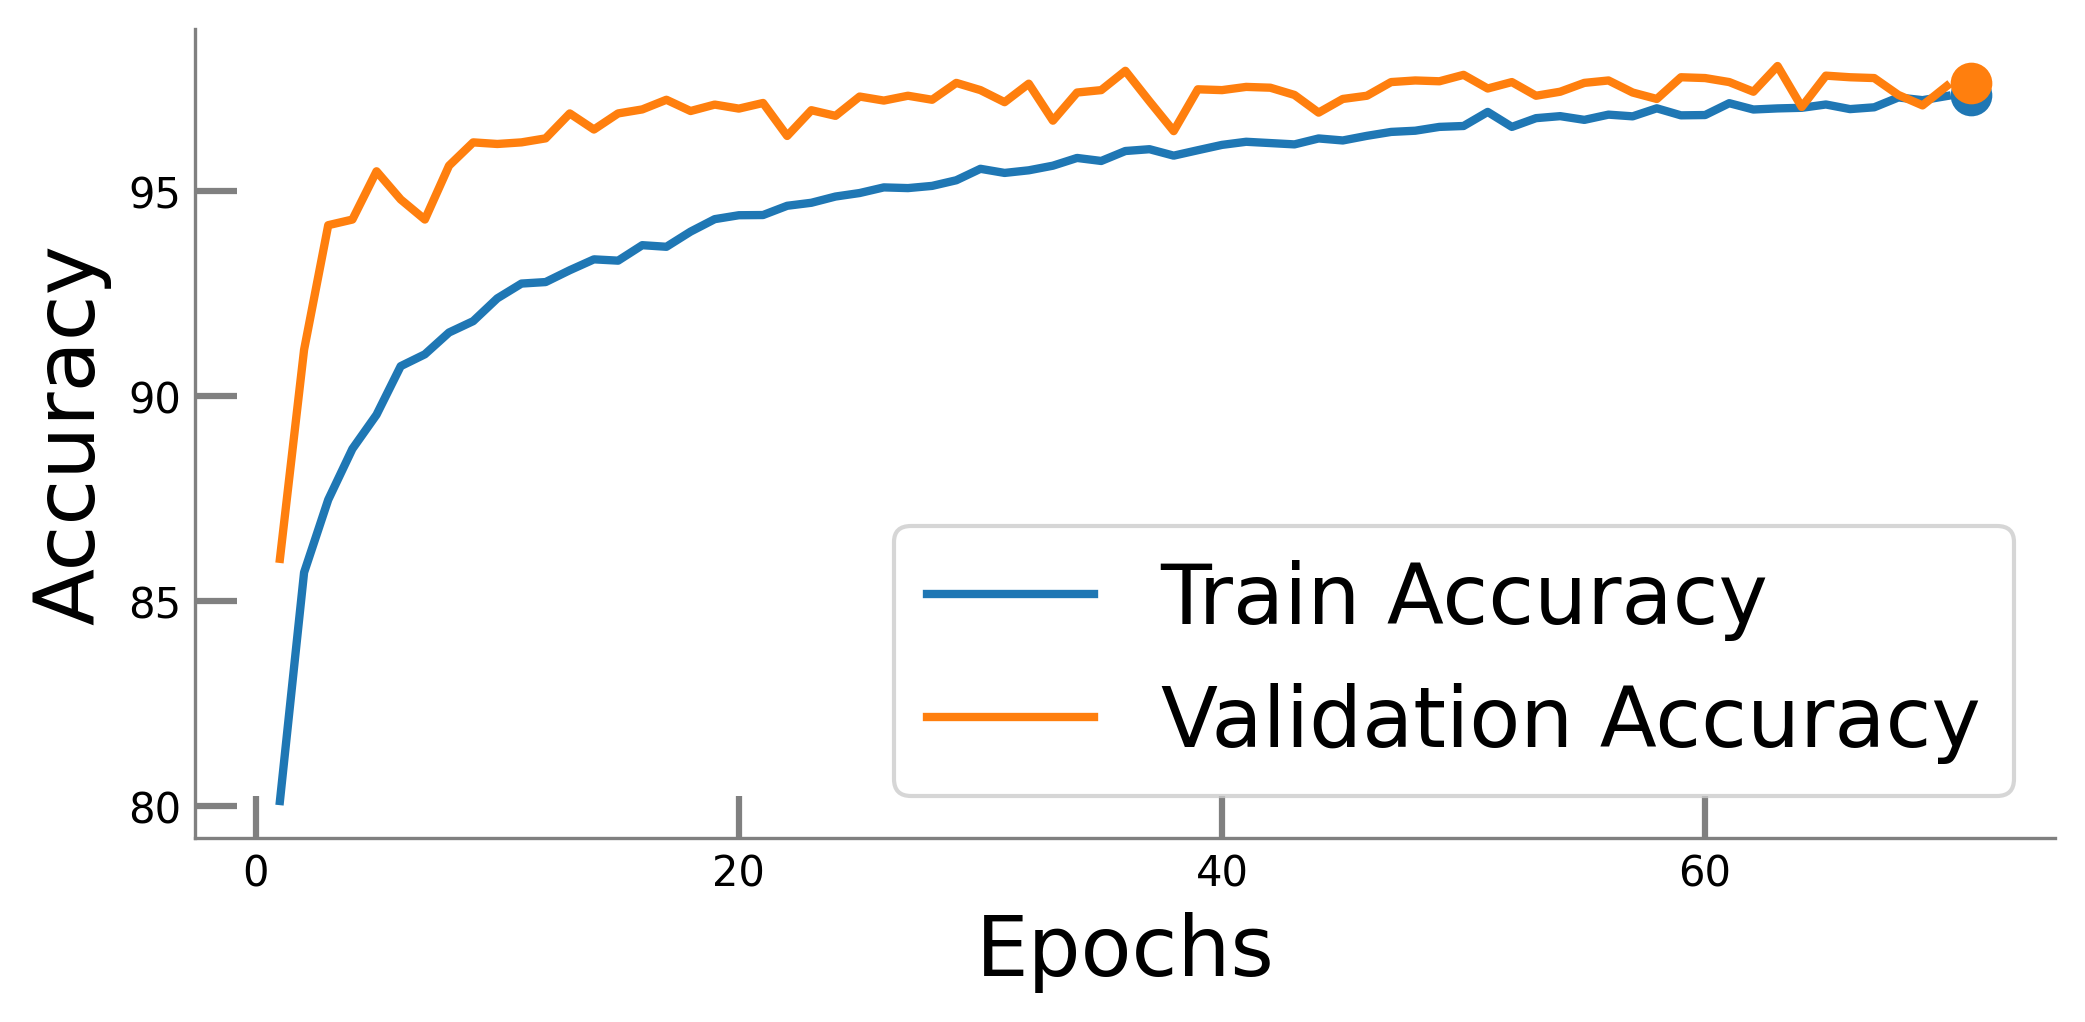

In [16]:

import matplotlib.pyplot as plt

# colors2 = ['#7bbbe0', '#e9a001']
colors2 = ['#1f77b4', '#ff7f0e']

# Plot the data
fig, ax = plt.subplots(figsize=(8,3.5), dpi= 300)
plt.plot(train_x_values[:70], train_y_values[:70], color = colors2[0], lw=2, label='Train Accuracy')
plt.plot(val_x_values[:70], val_y_values[:70], color = colors2[1], lw=2,label='Validation Accuracy')
plt.plot(train_x_values[70], train_y_values[70], 'o', markerfacecolor = colors2[0], markersize=10, markeredgewidth=0.0)
plt.plot(val_x_values[70], val_y_values[70], 'o', markerfacecolor = colors2[1], markersize=10, markeredgewidth=0.0)


font_size=20
# font = {'family' : 'Arial', 'size'   : font_size}
font = {'size'   : font_size}
plt.rc('font', **font)
# plt.rc('text', usetex=False)
plt.rcParams['axes.linewidth'] = 1.50



# Set tick parameters
ax.tick_params(axis='both', length=10, width=1.5, color= 'gray', direction='in')

# Turn off the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the color of the axes
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')




# plt.title('Training vs Validation Accuracy', fontsize=font_size)
plt.xlabel('Epochs', fontsize=font_size)
plt.ylabel('Accuracy', fontsize=font_size)
plt.legend()

image_name = "Train_vs_validation_accuracy"
plt.savefig(image_name+ '.svg', format='svg', dpi=1200, bbox_inches='tight')
plt.savefig(image_name+ '.png', format='png', dpi=1200, bbox_inches='tight')


# ROC

In [17]:
model.eval()  # set the model to evaluation mode

# Variable for model predictions and true labels
y_pred = []
y_true = []

roc_data = {"test":[], 'val':[]}


with torch.no_grad():
    for image, target in test_dl:
        image, target = image.to(device), target.to(device)
        outputs = model(image)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        # Get the probability of the positive class (class 1)
        pos_probs = probs[:, 1]
        y_pred.extend(pos_probs.cpu().numpy())  # Save predicted probabilities
        target = target.data.cpu().numpy()
        y_true.extend(target)  # Save actual labels
        
        



from sklearn.metrics import roc_curve, auc
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
roc_data['test'] = [fpr, tpr, roc_auc]


with torch.no_grad():
    for image, target in val_dl:
        image, target = image.to(device), target.to(device)
        outputs = model(image)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        # Get the probability of the positive class (class 1)
        pos_probs = probs[:, 1]
        y_pred.extend(pos_probs.cpu().numpy())  # Save predicted probabilities
        target = target.data.cpu().numpy()
        y_true.extend(target)  # Save actual labels
        
        



from sklearn.metrics import roc_curve, auc
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
roc_data['val'] = [fpr, tpr, roc_auc]


In [18]:
print(roc_data)

{'test': [array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+

<Figure size 640x480 with 0 Axes>

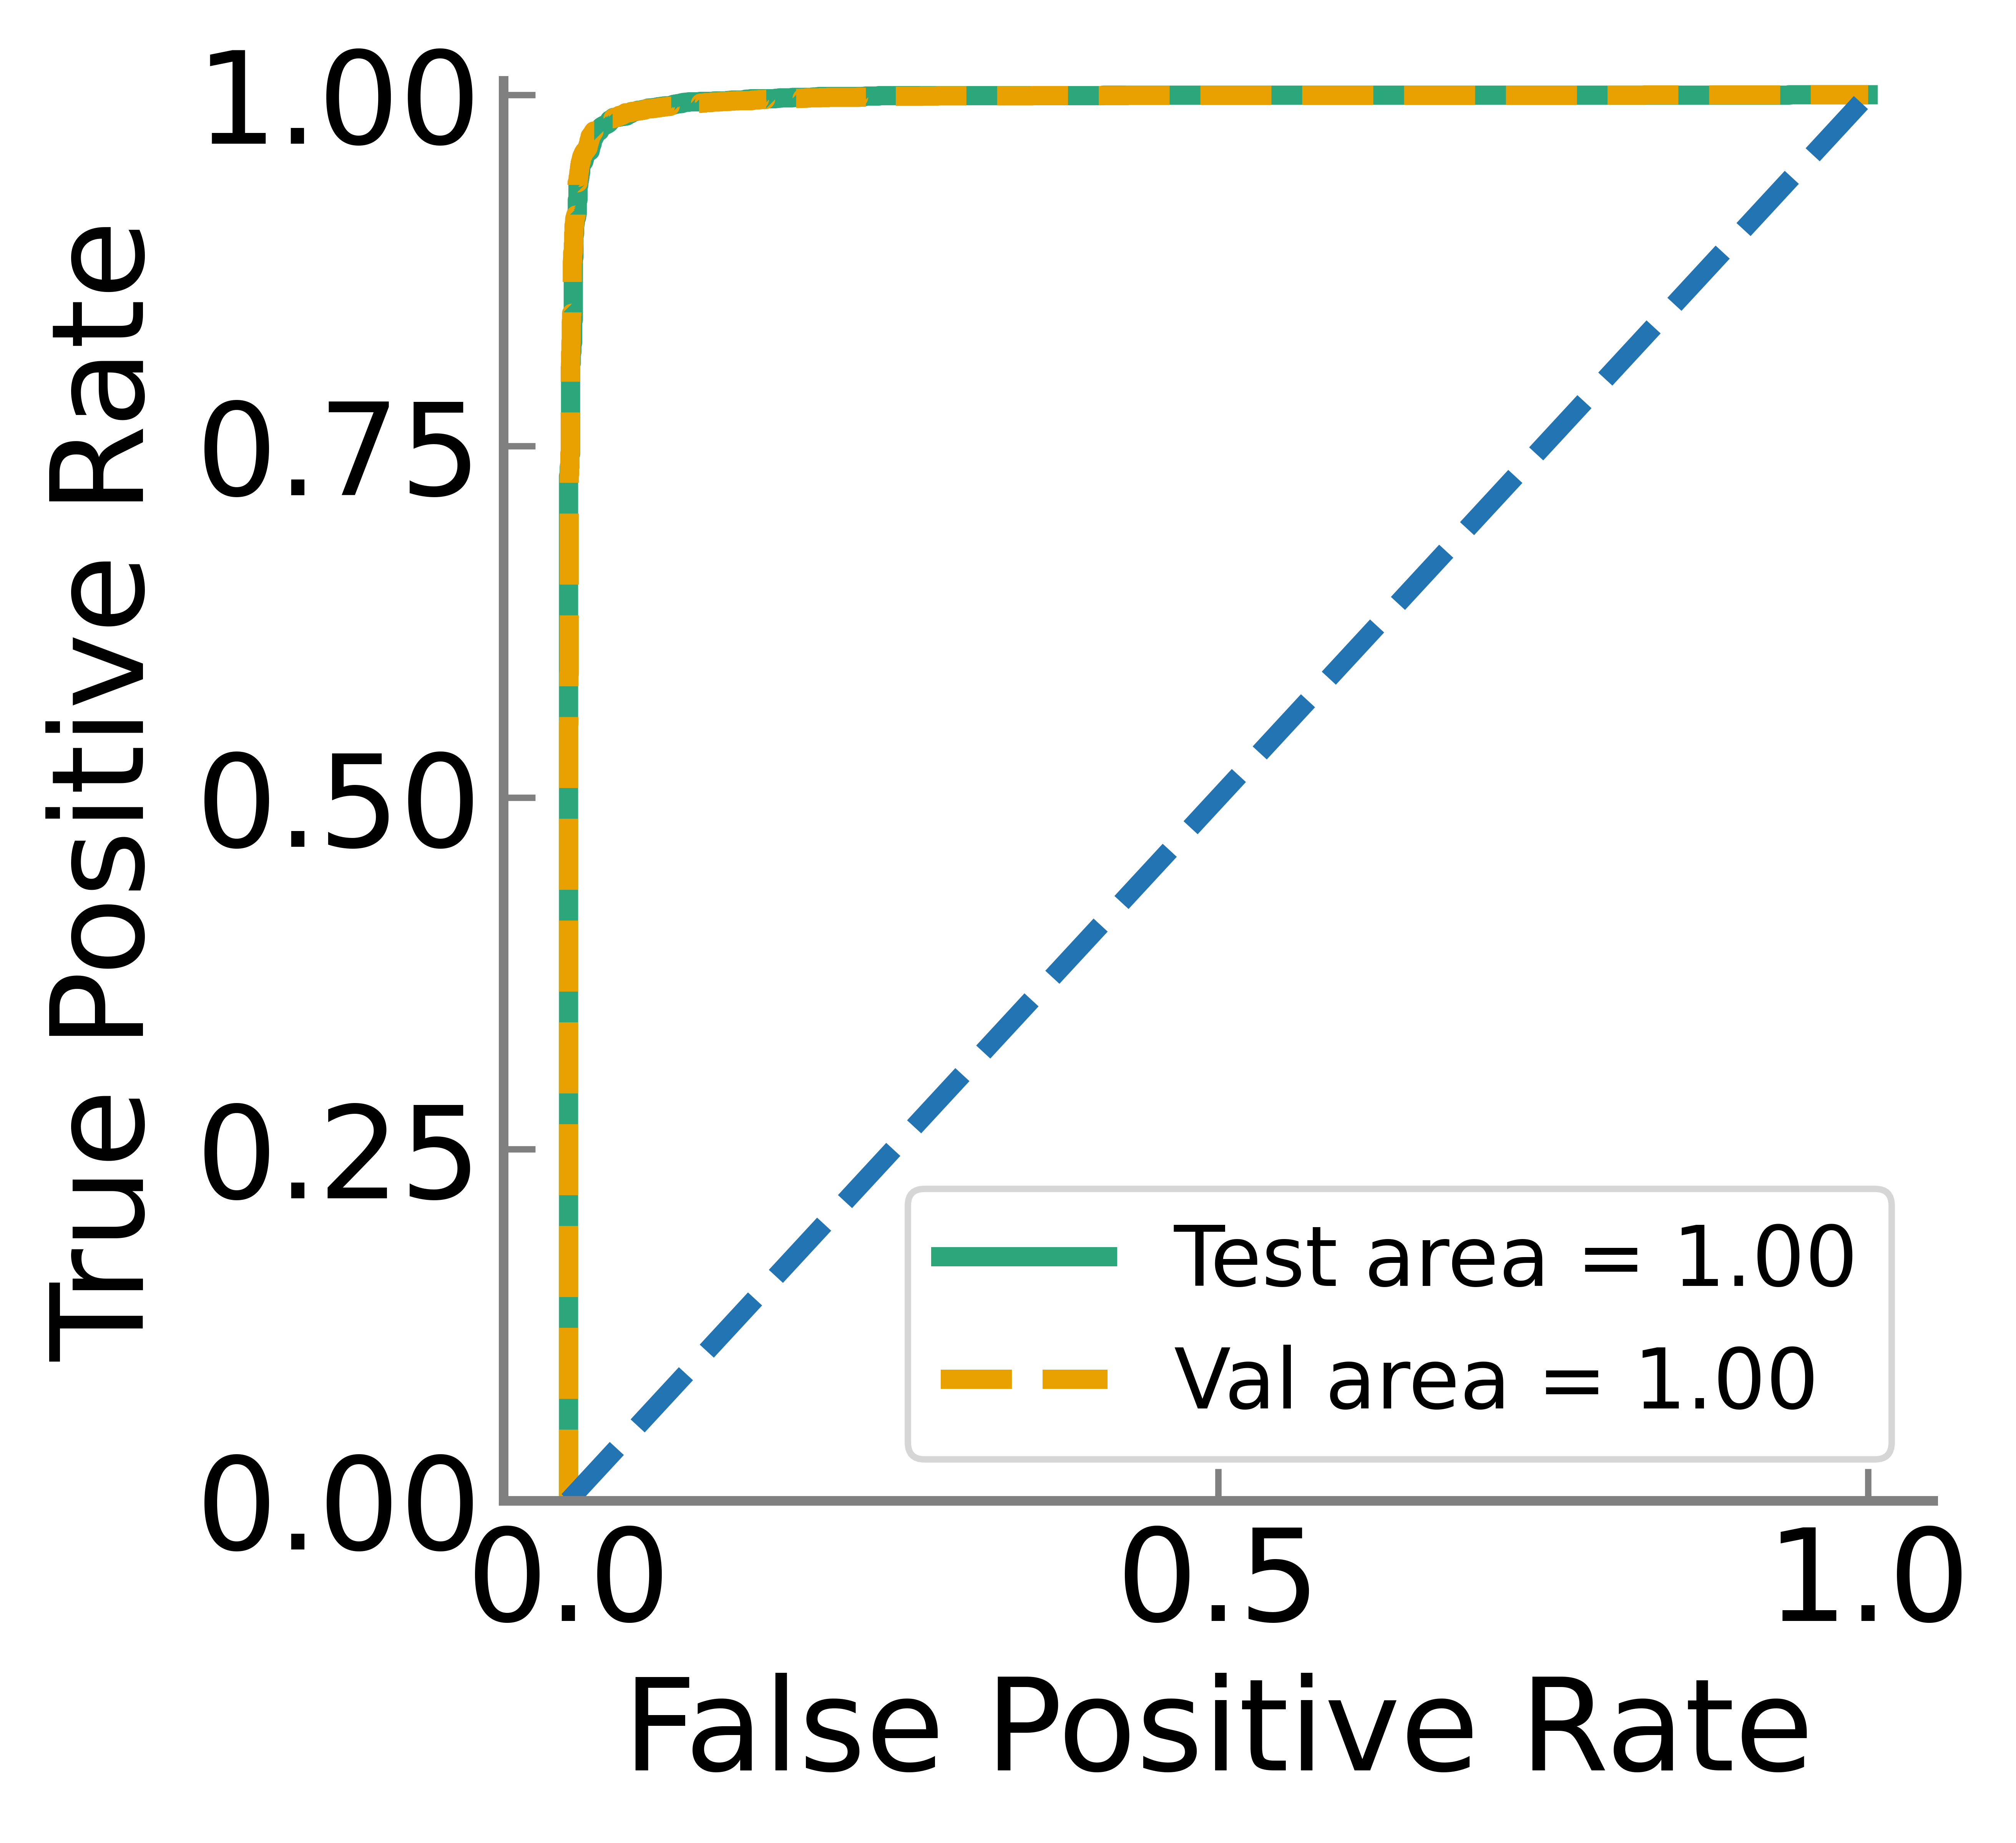

In [19]:
import matplotlib.pyplot as plt

# Plot ROC curve
plt.figure()
lw = 3  # line width
multiplier = 0.9
colors3 = ['#2ba77b', '#e9a001', '#2274b2']

fig, ax = plt.subplots(figsize=(4,4), dpi= 1200)

fpr, tpr, roc_auc = roc_data['test']

# fpr, tpr, roc_auc = np.array(fpr)*multiplier, np.array(tpr)*multiplier, roc_auc*multiplier

plt.plot(fpr, tpr, '-', color=colors3[0], lw=lw, label='Test area = %0.2f' % roc_auc)

fpr, tpr, roc_auc = roc_data['val']
# fpr, tpr, roc_auc = np.array(fpr)*multiplier, np.array(tpr)*multiplier, roc_auc*multiplier
plt.plot(fpr, tpr, '--', color=colors3[1], lw=lw, label='Val area = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=colors3[2], lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])



# plt.legend(loc="lower right")
# plt.show()



font_size=20
# font = {'family' : 'Arial', 'size'   : font_size}
font = {'size'   : font_size}
plt.rc('font', **font)
# plt.rc('text', usetex=True)
plt.rcParams['axes.linewidth'] = 1.50



# Set tick parameters
ax.tick_params(axis='both', length=5, width=1, color= 'gray', direction='in')

# Turn off the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the color of the axes
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic example')
plt.legend(fontsize=font_size*0.65, loc="lower right")


# Modify x and y tick labels
xticks = ax.get_xticks()
yticks = ax.get_yticks()

# Remove the first tick
# if len(xticks) > 1:
#     ax.set_xticks(xticks[1:])
# if len(yticks) > 1:
#     ax.set_yticks(yticks[1:])

# # plt.show()
image_name = "CNN_ROC"
plt.savefig(image_name+ '.svg', format='svg', dpi=1200, bbox_inches='tight')
plt.savefig(image_name+ '.png', format='png', dpi=1200, bbox_inches='tight')


# Confusion matrix

## Test data

In [20]:
import numpy as np

# Example usage:
y_true, y_pred = evaluate_model(model, test_dl, device)

from sklearn.metrics import confusion_matrix
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

accuracy = np.trace(cm) / np.sum(cm)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.98


/tmp/ipykernel_704891/2455275798.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  original_cmap = plt.cm.get_cmap('rocket')


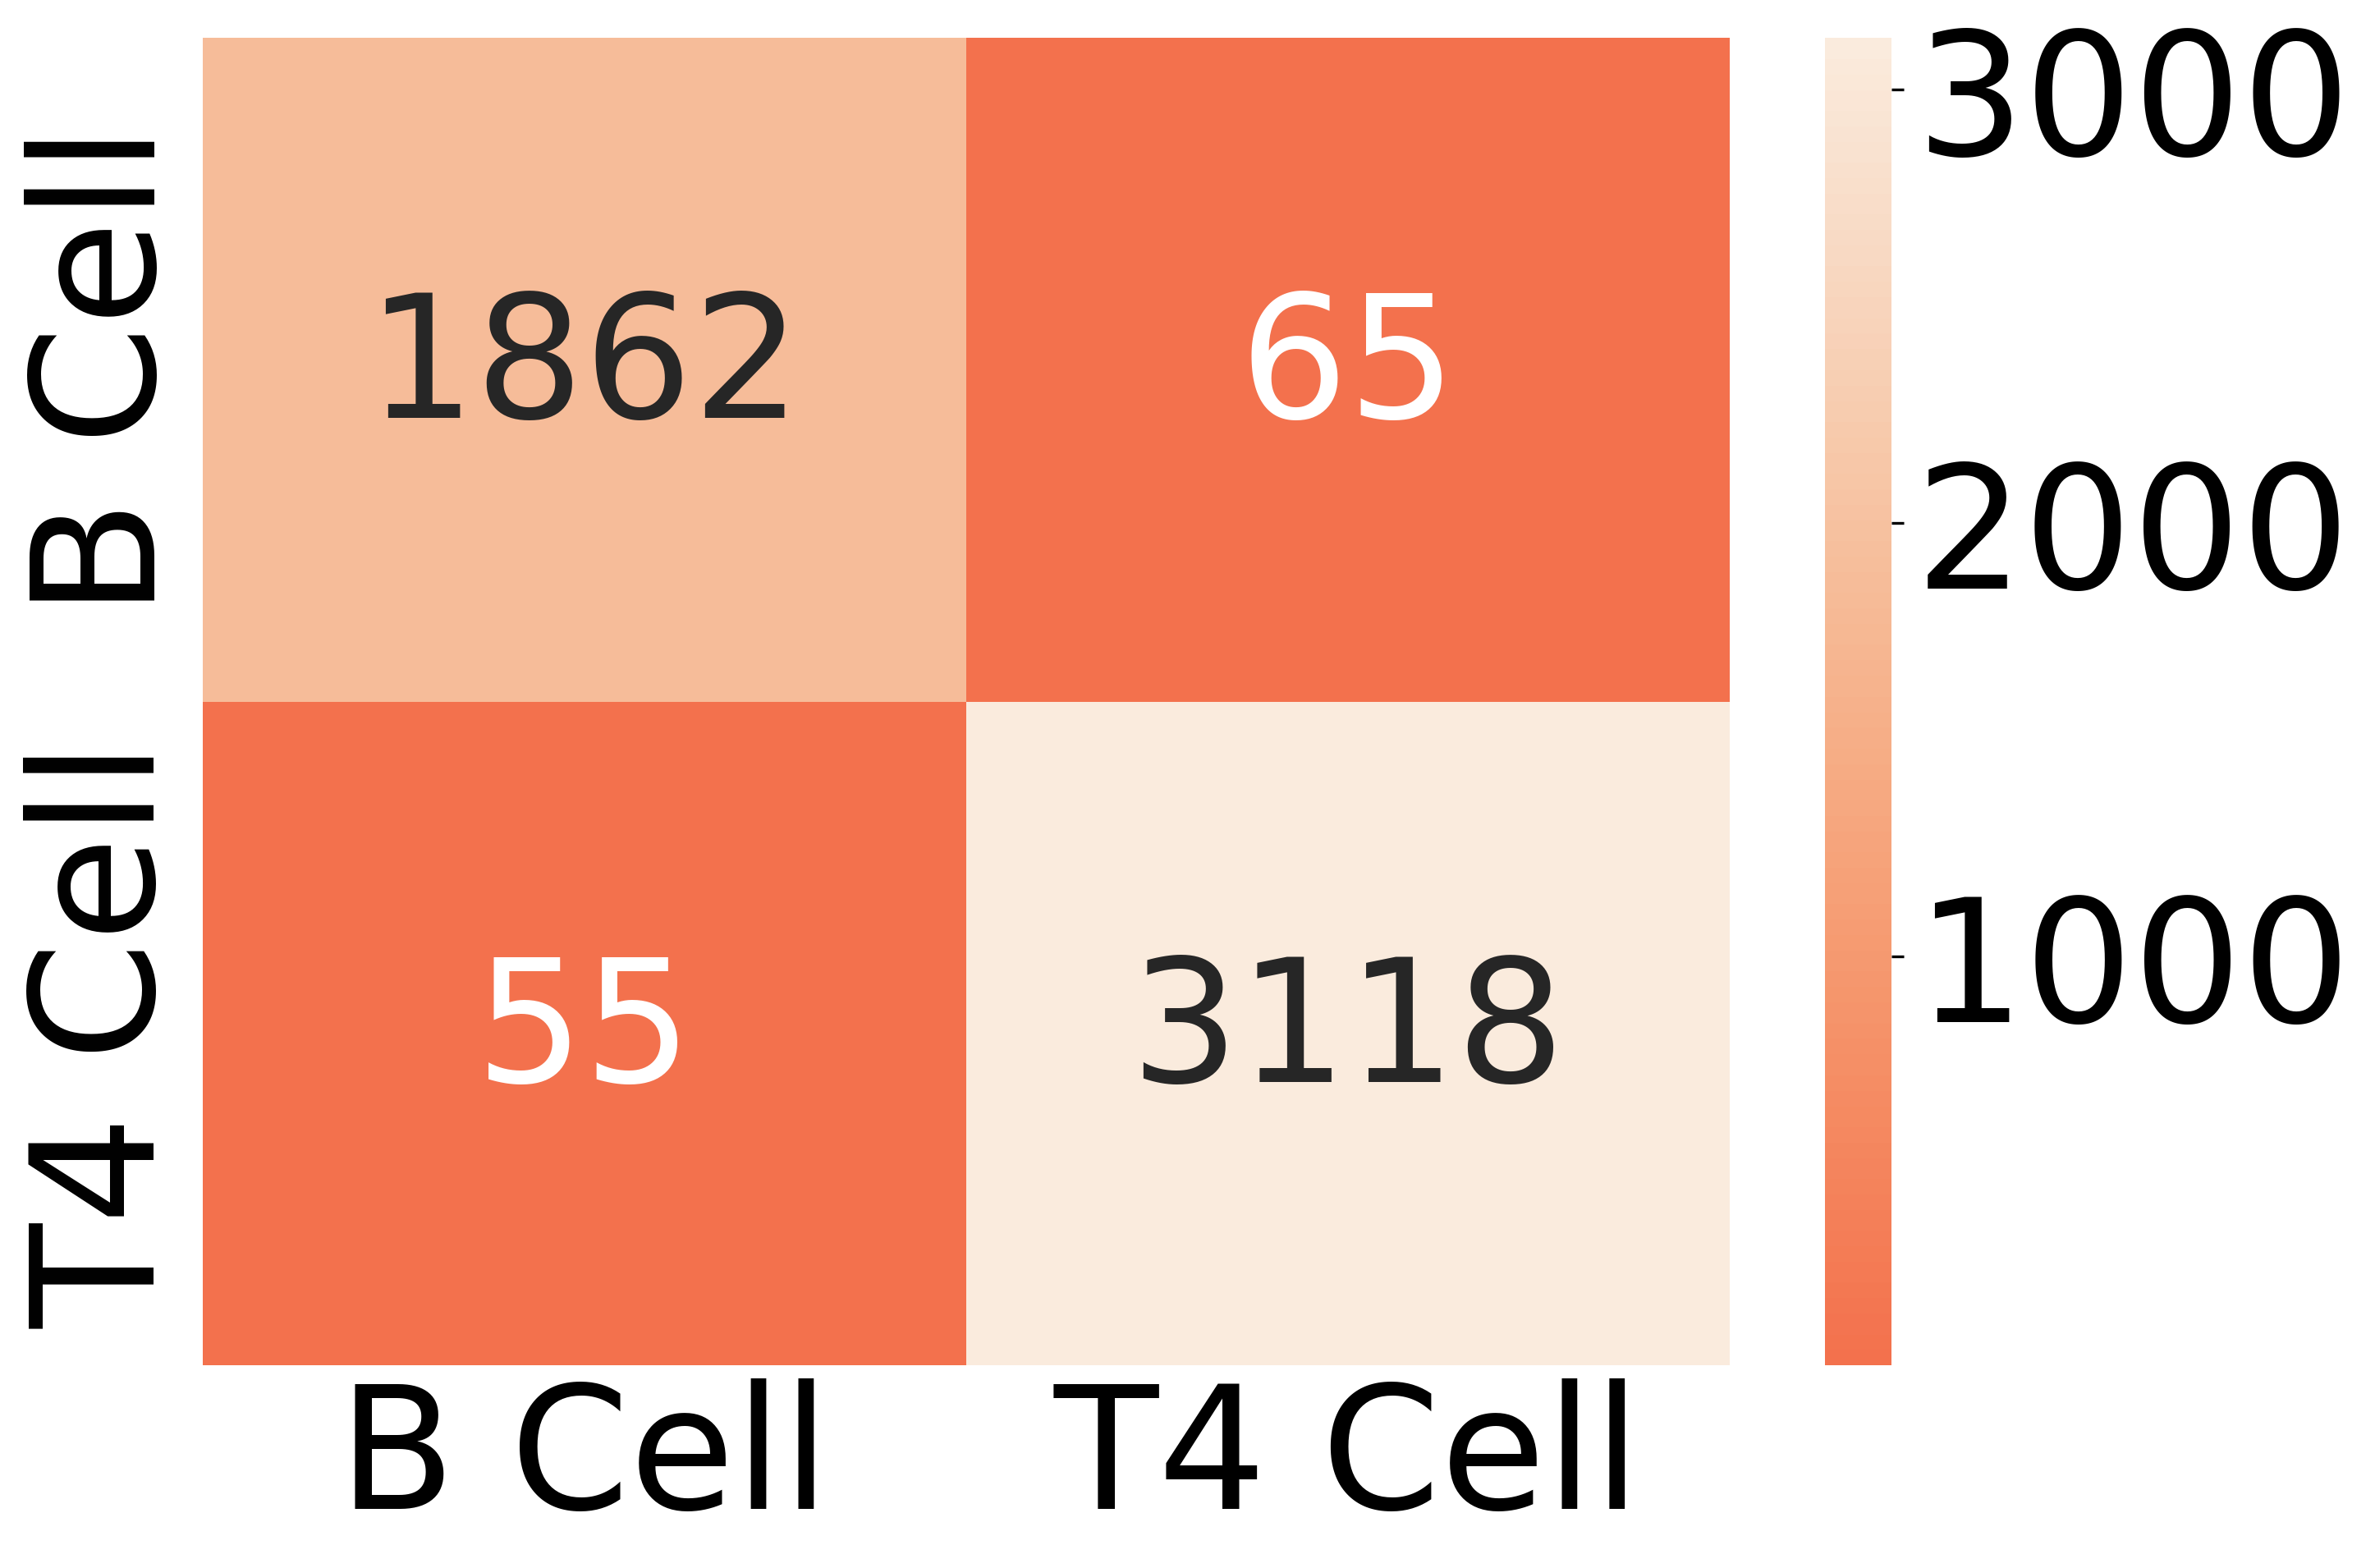

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns





font_size=50
# font = {'family' : 'Arial', 'size'   : font_size}
font = {'size'   : font_size}
plt.rc('font', **font)
# plt.rc('text', usetex=True)
plt.rcParams['axes.linewidth'] = 1.50

# Define tick labels
labels = ["B Cell", "T4 Cell"]

fig, ax = plt.subplots(figsize=(10,7), dpi= 300)

original_cmap = plt.cm.get_cmap('rocket')
# create new colormap using the top 40%
new_cmap = plt.cm.colors.ListedColormap(original_cmap(np.linspace(0.7, 1, 256)))


ax = sns.heatmap(cm, annot=True, fmt="d", cmap=new_cmap, xticklabels=labels, yticklabels=labels)
# Set tick parameters
ax.tick_params(axis='both', length=5, width=0.0, color= 'gray', direction='in')


image_name = "Confusion_test"
plt.savefig(image_name+ '.svg', format='svg', dpi=1200, bbox_inches='tight')
plt.savefig(image_name+ '.png', format='png', dpi=1200, bbox_inches='tight')

### Val data

In [22]:

# Example usage:
y_true, y_pred = evaluate_model(model, val_dl, device)

from sklearn.metrics import confusion_matrix
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

accuracy = np.trace(cm) / np.sum(cm)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.98


/tmp/ipykernel_704891/1748460348.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  original_cmap = plt.cm.get_cmap('rocket')


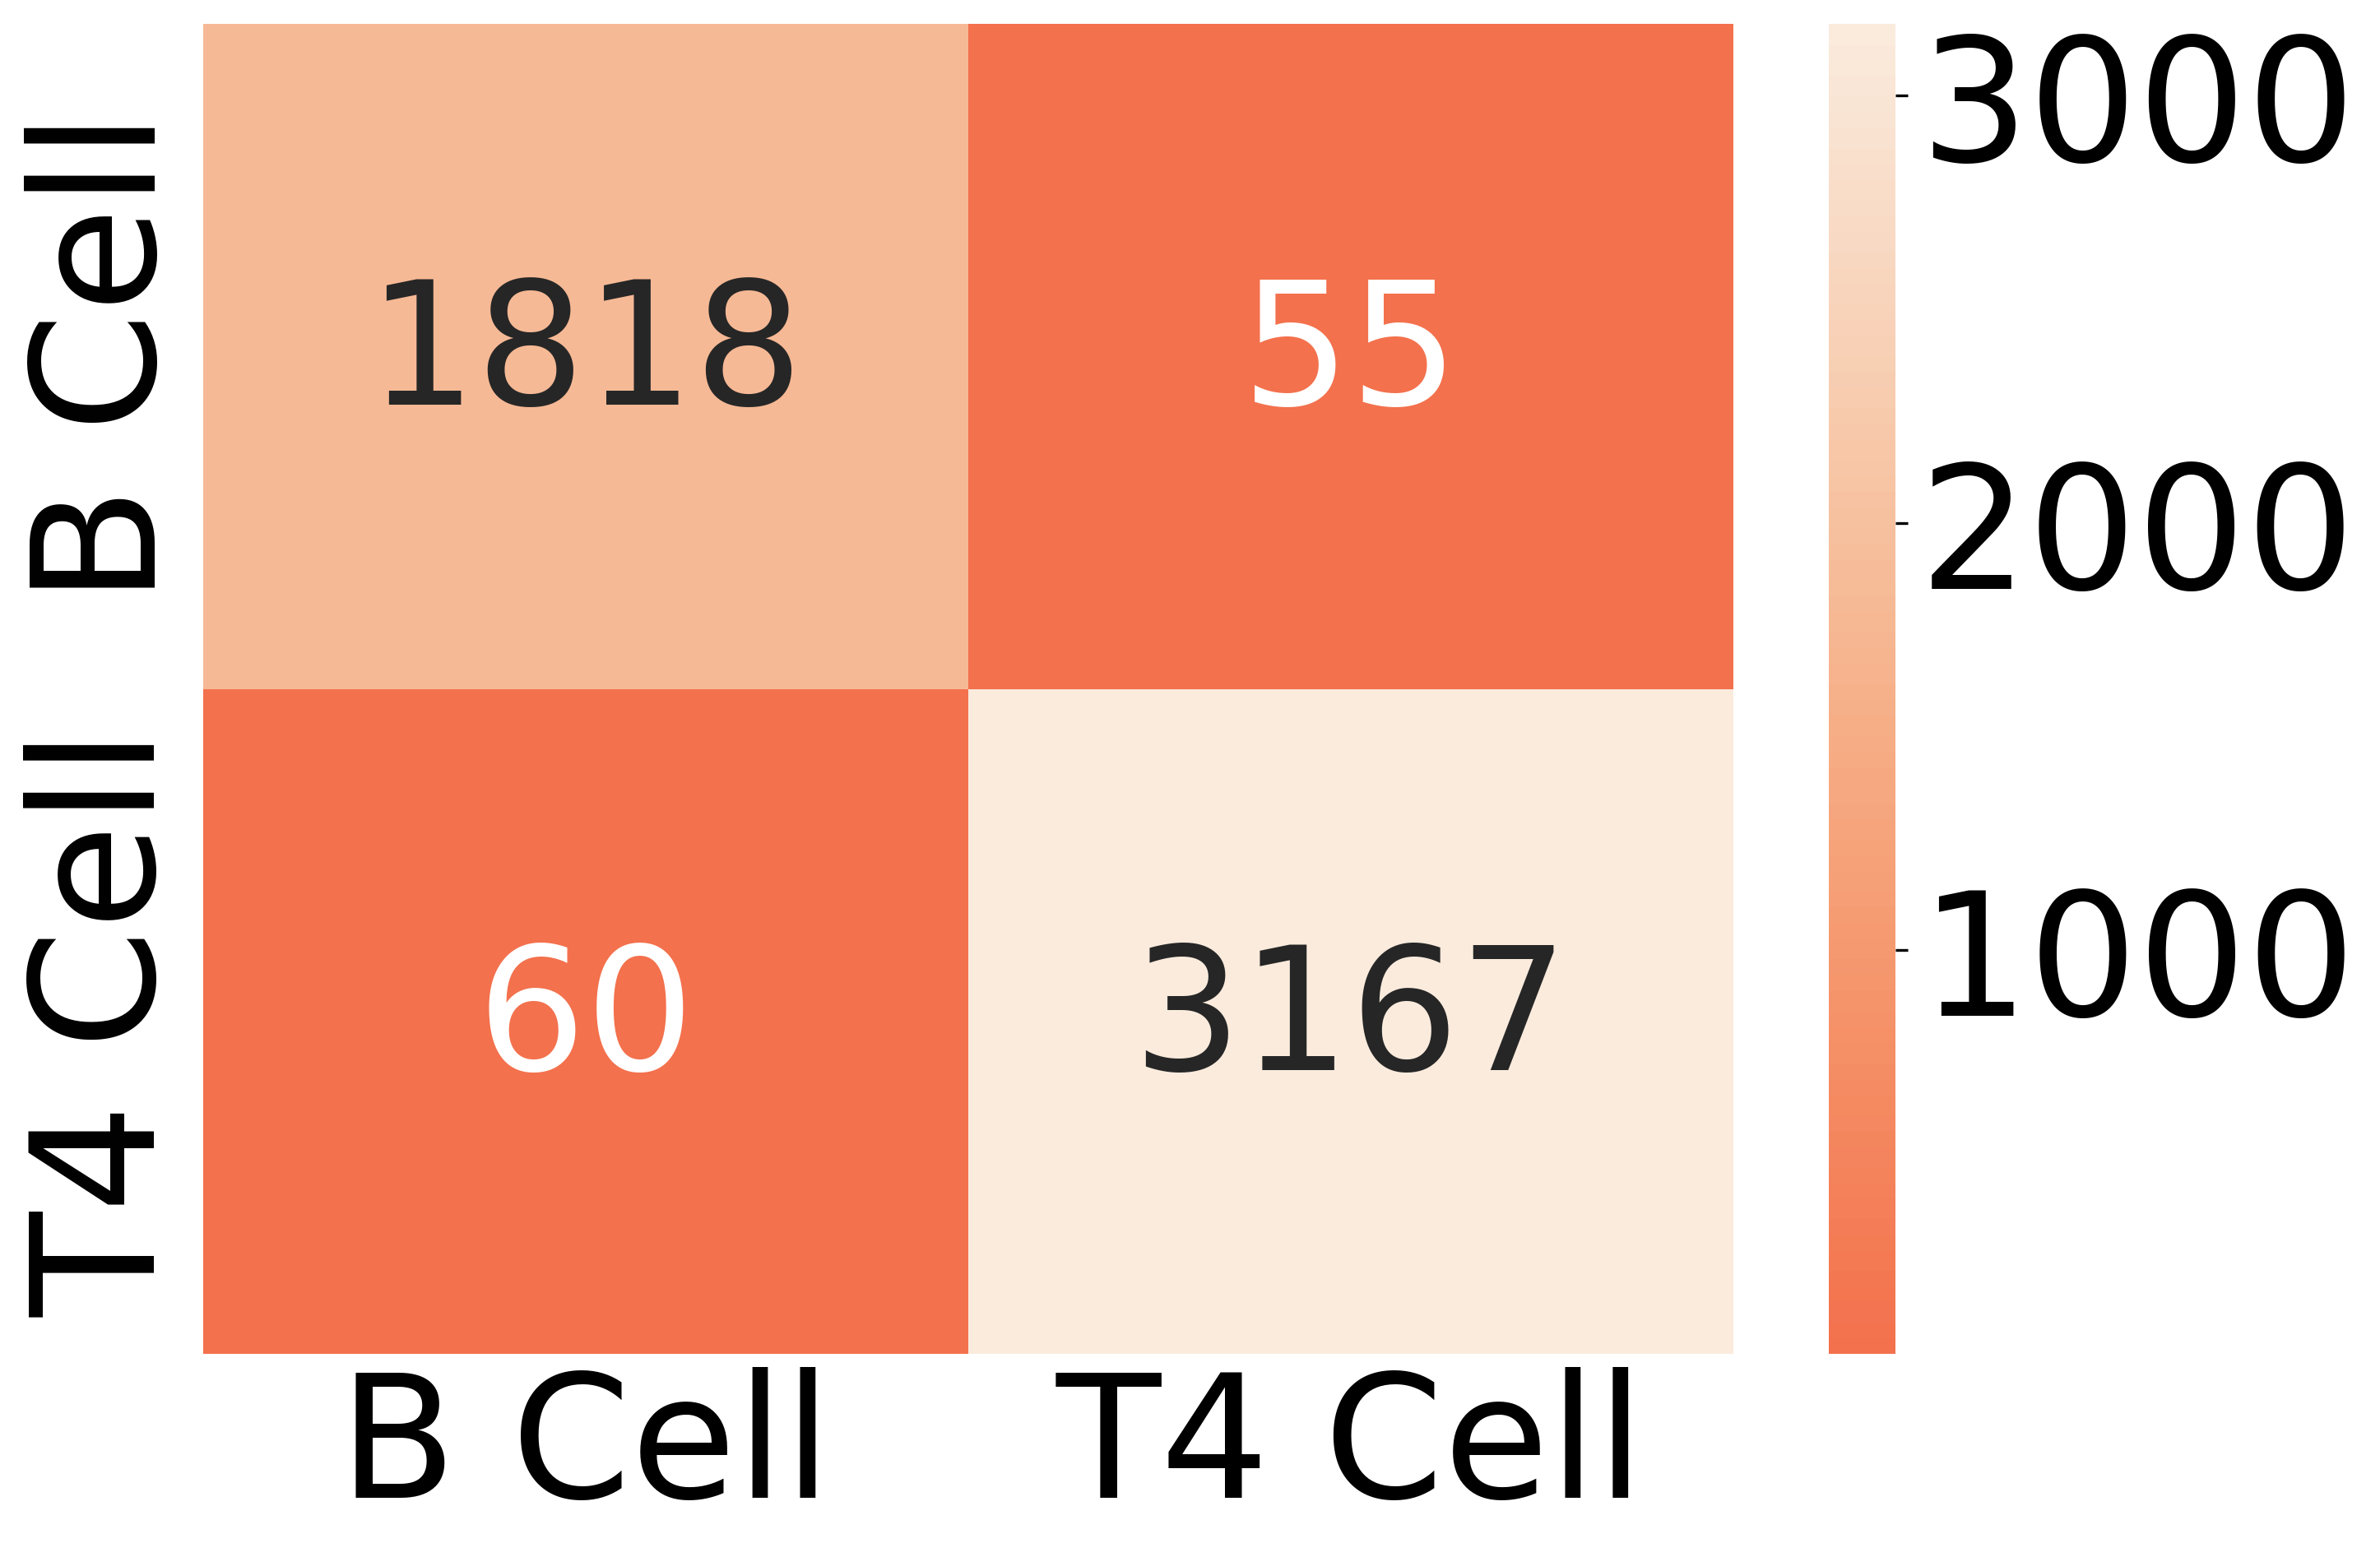

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



font_size=50
# font = {'family' : 'Arial', 'size'   : font_size}
font = {'size'   : font_size}
plt.rc('font', **font)
# plt.rc('text', usetex=True)
plt.rcParams['axes.linewidth'] = 1.50

# Define tick labels
labels = ["B Cell", "T4 Cell"]

fig, ax = plt.subplots(figsize=(10,7), dpi= 300)

original_cmap = plt.cm.get_cmap('rocket')
# create new colormap using the top 40%
new_cmap = plt.cm.colors.ListedColormap(original_cmap(np.linspace(0.7, 1, 256)))


ax = sns.heatmap(cm, annot=True, fmt="d", cmap=new_cmap, xticklabels=labels, yticklabels=labels)
# Set tick parameters
ax.tick_params(axis='both', length=5, width=0.0, color= 'gray', direction='in')


image_name = "Confusion_val"
plt.savefig(image_name+ '.svg', format='svg', dpi=1200, bbox_inches='tight')
plt.savefig(image_name+ '.png', format='png', dpi=1200, bbox_inches='tight')

# TSNE

In [ ]:
print(model)

In [24]:
# defining hook to access output from intermidiate layer
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

# registerning the hook. different layer can be accessed by changing
# fc[3] parameter. for details 
# https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/05/27/extracting-features.html

# print(model)
model.layer4[2].conv3.register_forward_hook(get_features('feats'))
# cnn.conv1.register_forward_hook(get_features('feats'))


y_pred = []
y_true = []
FEATS = [] # extracted feats will be saved here
# placeholder for batch features
features = {}
# targets = []

with torch.no_grad():
    for image, targets in test_dl:
        image, targets = image.to(device), targets.to(device)
        outputs = model(image)
        preds = (torch.max(outputs, 1)[1]).data.cpu().numpy()
        # y_pred.extend(output) # Save Prediction
        # target = target.data.cpu().numpy()
        
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(preds)
        
        
        # targets.extend(target) # Save target
        FEATS.extend((features['feats'].cpu().numpy())) # Save feature
        
y_pred, y_true = np.array(y_pred).reshape(-1,1), np.array(y_true).reshape(-1,1)
FEATS = np.array(FEATS)
print(f' Feature extracted with shape: (m, C, H, W) = {np.array(FEATS).shape}')

 Feature extracted with shape: (m, C, H, W) = (5100, 2048, 4, 4)


In [25]:
# from sklearn.manifold import TSNE

# # Load the dataset and perform t-SNE embedding
# tsne_proj = TSNE(n_components=2, perplexity= 20,n_iter=400).fit_transform(FEATS.reshape(FEATS.shape[0], -1))

# # save the t-SNE projection
# import pandas as pd
# df = pd.DataFrame(np.concatenate((tsne_proj, y_pred, y_true), axis=1))
# df.to_csv('feats.csv', index=False)

/home/mdi220/.virtualenvs/tvsb/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [26]:
import pandas as pd
import numpy as np

df = pd.read_csv('feats.csv')

# FEATS = last two colimns
tsne_proj = df.iloc[:, -4:-2].values
y_pred, y_true = df.iloc[:, -2].values, df.iloc[:, -1].values
print(f' TSNE shape: (m, n) = {np.array(tsne_proj).shape}')

 TSNE shape: (m, n) = (5100, 2)


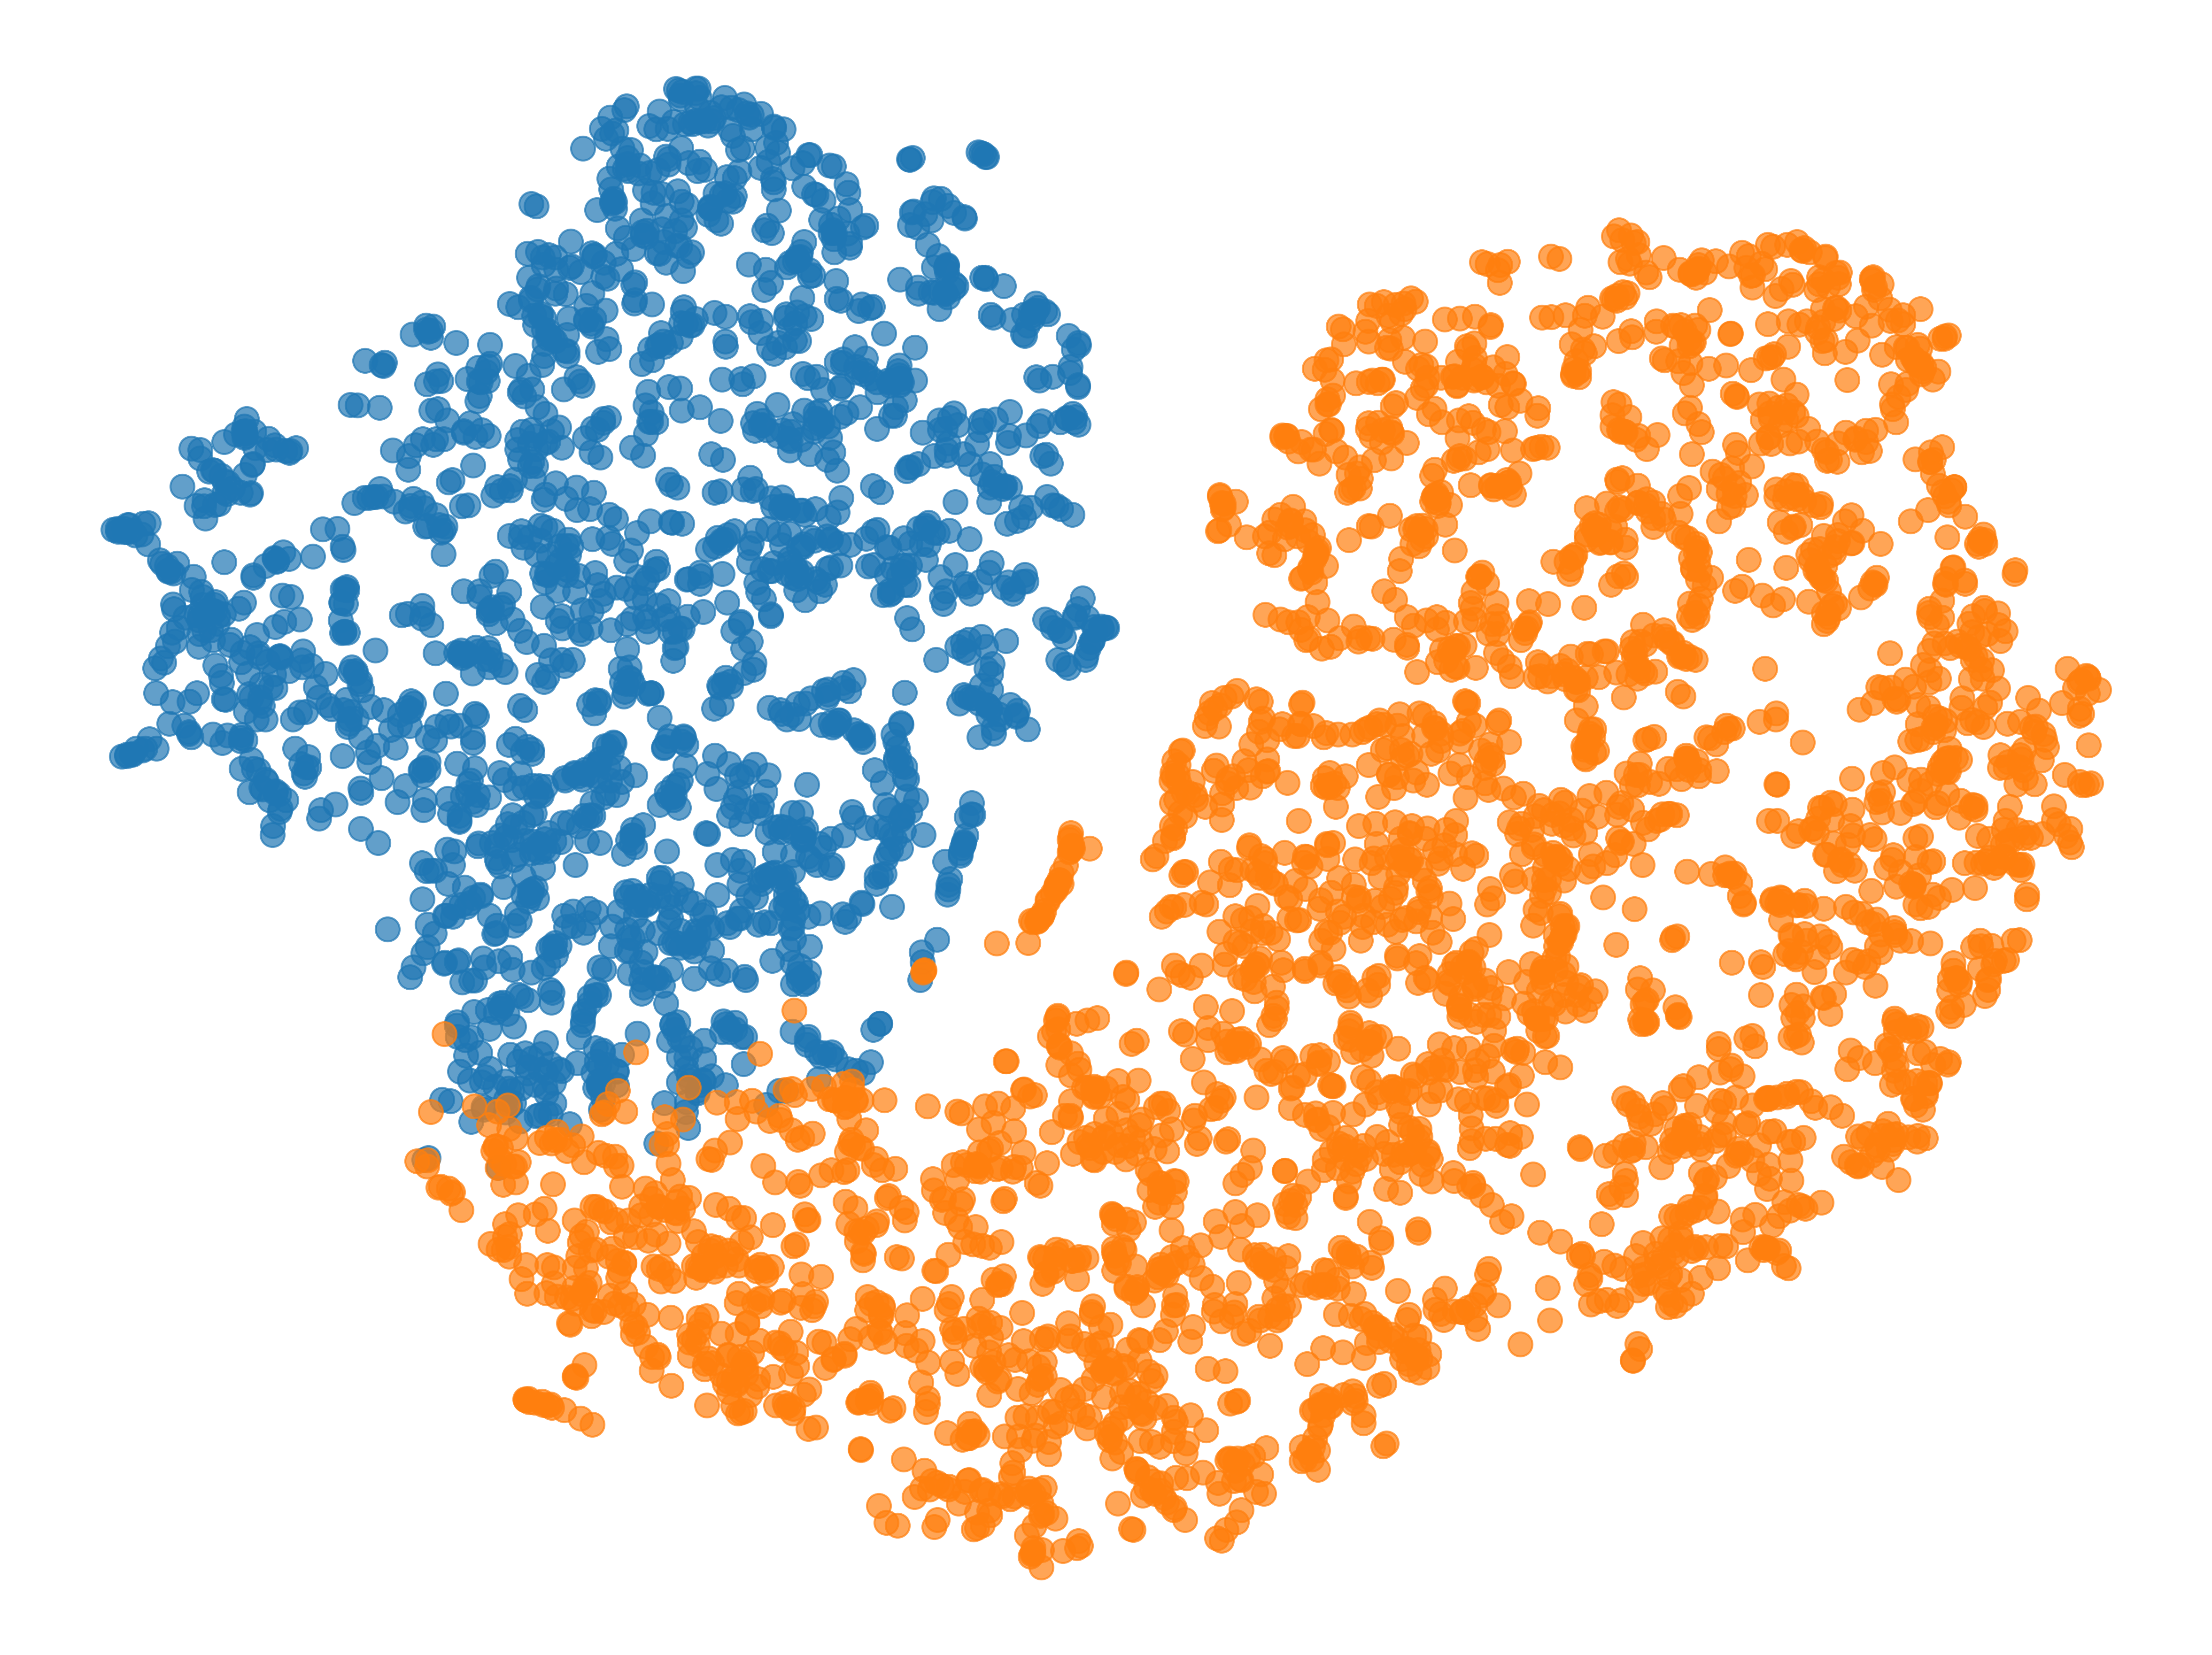

In [27]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import numpy as np

colors2 = ['#1f77b4', '#ff7f0e'] # matplotlib default color cycle
font_size=50
# font = {'family' : 'Arial', 'size'   : font_size}
font = {'size'   : font_size}
plt.rc('font', **font)
plt.rc('text', usetex=True)
plt.rcParams['axes.linewidth'] = 1.50


fig, ax = plt.subplots(figsize=(20,15), dpi= 300)

# Rename the ticks
plot_labels = ['B Cell', 'T4 Cell']  

for lab in range(2):
    indices = np.array(y_pred)==lab
    indices_flat = indices.flatten()

    sc = ax.scatter(tsne_proj[indices_flat,0],tsne_proj[indices_flat,1], s=150, color=colors2[lab],  label = plot_labels[lab], alpha=0.7)


# plt.legend(fontsize=35)
plt.axis('off')

image_name = "TSNE_visu"
plt.savefig(image_name+ '.svg', format='svg', dpi=1200, bbox_inches='tight')
plt.savefig(image_name+ '.png', format='png', dpi=1200, bbox_inches='tight')

# Inference time

In [ ]:
import time

# Hyperparameters
params = {
    'batch_size': 16,  # Standard batch size
    'im_size': 120,     # Resize dimension used during training
    'num_warmup_batches': 5,  # Number of warmup batches
    'num_batches': 100,  # Number of batches to measure (should cover 1000 images)
}

In [ ]:

import numpy as np
# Function to calculate inference speed
def calculate_inference_speed(loader, model, device, num_batches, warmup_batches):
    model.eval()
    total_time = 0.0
    images_processed = 0
    
    # Warm-up loop
    with torch.no_grad():
        for i, (images, _) in enumerate(loader):
            if i >= warmup_batches:
                break
            images = images.to(device)
            _ = model(images)

    # Timed inference loop
    with torch.no_grad():
        for i, (images, _) in enumerate(loader):
            if i >= num_batches:
                break
            images = images.to(device)

            start_time = time.time()  # Start timing
            _ = model(images)
            end_time = time.time()  # End timing

            # Update total time and images processed
            total_time += (end_time - start_time)
            images_processed += images.size(0)

    avg_inference_time_per_image = total_time / images_processed
    images_per_second = 1.0 / avg_inference_time_per_image
    return avg_inference_time_per_image, images_per_second

# Run the inference test for 50 iterations and collect the results
inference_times = []
inference_speeds = []

for i in range(50):
    avg_time, throughput = calculate_inference_speed(test_dl, model, device, params['num_batches'], params['num_warmup_batches'])
    inference_times.append(avg_time)
    inference_speeds.append(throughput)
    # print(f'Inference Time: {i}: {avg_time:.6f} seconds, Speed: {throughput:.2f} images/second')

# Calculate the average and standard deviation of inference times and speeds
mean_time = np.mean(inference_times)
std_time = np.std(inference_times)
mean_speed = np.mean(inference_speeds)
std_speed = np.std(inference_speeds)

print(f'Average Inference Time per Image (over 50 runs): {mean_time:.6f} seconds ± {std_time:.6f}')
print(f'Average Inference Speed (over 50 runs): {mean_speed:.2f} images/second ± {std_speed:.2f}')

Average Inference Time per Image (over 50 runs): 0.000252 seconds ± 0.000008
Average Inference Speed (over 50 runs): 3979.52 images/second ± 114.05